Often the easiest way to classify images is simply to use a pre-trained image classifier, but sometimes building a classifier from scratch is the way you want to go. This notebook aims to compare both a custom classifier and a pre-trained Convolutional Neural Network architecture. It will go over the implementation of both methods: custom and pre-trained architectures (ResNet and Inception). 

We'll be classifying the Flowers Recognition dataset, which contains 4242 images of different flowers, divided into five different classes: daisy, dandelion, rose, sunflower, tulip.

First, here's all the imports we will be using.

In [ ]:
import random as rn
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Flatten, Activation
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

Before we can start building a network architecture and classifying images, we need to load in the images and create a dataset. When we create our dataset we'll need our features/images and labels, so we'll create a list to hold both. We'll then specify what size the images should be. We'll go with 150 x 150 in this case, and rescale all images to that size. 

In [ ]:
# separating training data into different folders

images = []
labels = []

img_size = 150

Now we can go about creating the training data. We'll create a function to convert the images into a dataset and apply a label to the images.

By using `tqdm` we can get a progress bar that will show us the progress of the images being converted into a dataset. Our function will take in the class of the images, as well as the directory the images are in. It will get the name of the label from the name of the directory. It will then loop through the images, and assuming it is a .jpg, it will load the image in using CV2, appending it to our list of images we created earlier.

In [ ]:
def training_data(im_class, dir):
    # tqdm is for the display of progress bars
    # for the image in the listed directory
    for img in tqdm(os.listdir(dir)):
        label = im_class
        path = os.path.join(dir, img)
        _, ftype = os.path.splitext(path)
        if ftype == ".jpg":
            # read in respective image as a color image
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            # rsize the respective image
            img = cv2.resize(img, (img_size, img_size))

            # make a numpy array out of the image
            images.append(np.array(img))
            labels.append(str(label))

Now we can call the function and pass in both the label/image class and the directory to look for the images in.

In [ ]:
training_data('Daisy', '/flowers/daisy')
print(len(images))

training_data('Sunflower', '/flowers/sunflower')
print(len(images))

training_data('Tulip', '/flowers/tulip')
print(len(images))

training_data('Dandelion', '/flowers/dandelion')
print(len(images))

training_data('Rose', '/flowers/rose')
print(len(images))

We can't load raw text data into our classifier, so we'll need to encode the labels. We'll create an instance of the Label Encoder and convert the labels with it. We then need to one hot encode the data, so there's five distinct classes. We'll do this using Scikit-learn's `to_categorical` function. Finally, we convert the feature image data into a numpy array and normalize it by dividing it by 255.

In [ ]:
# do label encoding
encoder = LabelEncoder()
y_labels = encoder.fit_transform(labels)
# one hot encoding
y_labels = to_categorical(y_labels, 5)
x_features = np.array(images)
# data normalization
x_features = x_features/255

We'll now make our training and testing data by using the `train_test_split` function. We'll also set some random seeds for the sake of reproduceability. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.25, random_state=27)

np.random.seed(27)
rn.seed(27)
# graph level random seed for TF/Keras
tf.set_random_seed(27)

If we want to we can visualize some of the data here, just to make sure it has all loaded correctly. We first set up the plot, and then get a random label along with the image for that label, and then show both.

In [ ]:
# will make 5 x 2 subplots
fig, ax = plt.subplots(2, 5)
# set a specific size for the plot
fig.set_size_inches(15, 15)
# specify plotting on both axis
for i in range(2):
    for j in range(5):
        # get a random integer between one and the final label in the list of labels
        label = rn.randint(0, len(labels))
        ax[i, j].imshow(images[label])
        ax[i, j].set_title('Flower: '+labels[label])
plt.tight_layout()
plt.show()

We now need to take the images and make iterable data from them, something we can do with Keras' built-in `ImageDataGenerator`. We can also do some data augmentation/transforamtion by introducing random perturbations to the image. We can do this to help combat overfitting on the specific clean, formatted images in our dataset.

In [ ]:
# because the model is so large/deep it may be a good idea to perform some data augmentation in order
# combat overfitting
data_generator = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2,
                                    horizontal_flip=True)

# fit on the trainign data to produce more data with the specified transformations
data_generator.fit(X_train)

Let's now go about setting up our model. We declare the type of model we want to use (sequential) and then we can add layers to it. We'll use a function to create the model.

In [ ]:
def create_model():
    # first specify the sequential nature of the model
    model = Sequential()
    # conv2d is the convolutional layer for 2d images
    # first parameter is the number of memory cells - let's just try 64 units for now
    # second parameter is the size of the "window" you want the CNN to use
    # the shape of the data we are passing in, 3 x 150 x 150
    model.add(Conv2D(64, (5, 5), input_shape=(150, 150, 3), padding='same'))
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3),  padding='same'))
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # you'll need to flatten the data for the dense layer
    # which takes a long feature vector
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    # now compile the model, specify loss, optimization, etc
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Now we can create the model and specify some callbacks we would like to use. We'd like to use a checkpoint system and save the currents weights whenever validation accuracy improves. Also, whenever we hit a training plateau, we're going to reduce the learning rate, as that means the classifier is probably getting stuck oscillating around the minimum loss.

In [ ]:
model = create_model()
batch_size = 64
num_epochs = 50

# fit the generator, since we used one in making new data

filepath = "weights_custom.hdf5"
callbacks = [ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='min', min_lr=0.00001),
             EarlyStopping(monitor= 'val_loss', min_delta=1e-10, patience=15, verbose=1, restore_best_weights=True)]

Because we used the training data generator earlier, we must be sure to all the `fit_generator` function on the model. We pass in all our chosen arguments now, like callbacks, training epochs, and batch size. We're also going to save it in a variable so we can access the training history from it later.

In [ ]:
train_records = model.fit_generator(data_generator.flow(X_train, y_train, batch_size=batch_size), epochs = num_epochs,
                          validation_data=(X_test, y_test), verbose= 1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=callbacks)

Now we need to get the loss and accuracy on the training and validation sets, which we can pull from the history of our trained model. We'll also want the length of the training, to assist in plotting.

In [ ]:
# visualize training loss
# declare important variables
training_acc = train_records.history['acc']
val_acc = train_records.history['val_acc']
training_loss = train_records.history['loss']
validation_loss = train_records.history['val_loss']

# gets the lengt of how long the model was trained for
train_length = range(1, len(training_acc) + 1)

We'll now create some functions to:

- Visualize the training and validation accuracy and loss
- Make some predictions and get a confusion matrix based on the predictions

The first function plots our statistics, first the loss and then the accuracy.
For the predictions function, we'll first print out the final achieved accuracy of our model and then make some predictions using the `predict` function. We'll do a confusion matrix on these predictions so we can get a better intuition of which classes the classifier is predicting accurately and which it is struggling with.

In [ ]:
def plot_stats(train_length, training_acc, val_acc, training_loss, validation_loss):

    # plot the loss across the number of epochs
    plt.figure()
    plt.plot(train_length, training_loss, label='Training Loss')
    plt.plot(train_length, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(train_length, training_acc, label='Training Accuracy')
    plt.plot(train_length, val_acc, label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def make_preds(model):
    # make predictions
    score = model.evaluate(X_test, y_test, verbose=0)
    print('\nAchieved Accuracy:', score[1],'\n')

    y_pred = model.predict(X_test)
    # evalute model predictions
    Y_pred_classes = np.argmax(y_pred, axis=1)
    Y_true = np.argmax(y_test, axis=1)
    confusion = confusion_matrix(Y_true, Y_pred_classes)
    print(confusion)

Now we just have to call the functions to see how the model trained and performed.

In [ ]:
plot_stats(train_length, training_acc, val_acc, training_loss, validation_loss)
make_preds(model)

Here were my training results for this model.

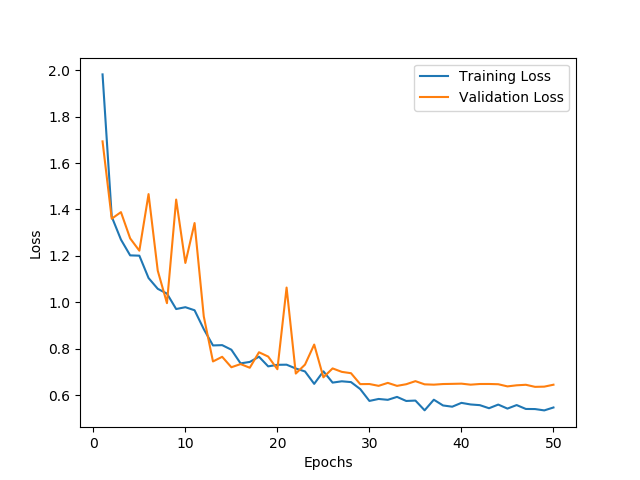
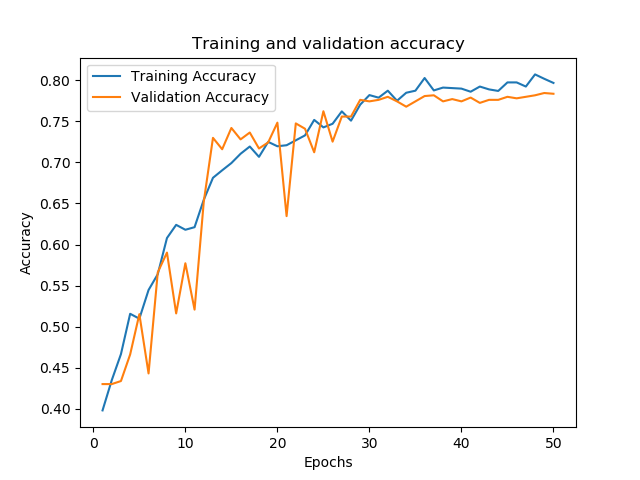

Achieved Accuracy: 0.7835337644258547

    [[151  21  19   9   4]
     [ 19 229   5  19   6]
     [  4   6 137   3  14]
     [  2  11   6 173   7]
     [  5  15  49  10 157]]

That's the implementation of our custom classifier. Now we'll contrast the performance of two premade classifiers: ResNet50 and InceptionV3.

Loading in the models is very simple, we just declare an instance of the model as the base architecture, create our sequential framework, and then add the model base to the framework. We can tell it which weights to use (those trained on Image Net) and tell it we don't wish to use the "Top" of the model, which is the densely connected layers. Since we have a different amount of classes than the network was trained on, we'll add in our own dense layers after adding in the base.

In [ ]:
# Create the base model and add it to our sequential framework
resnet = ResNet50(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))
print(resnet.summary())
resnet_model = Sequential()
resnet_model.add(resnet)

# Add in our own densely connected layers (after flattening the inputs)
resnet_model.add(Flatten())
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(5, activation='softmax'))
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(resnet_model.summary())

All that remains is to fit the generator, just like we did before.

In [ ]:
num_epochs = 10

filepath = "weights_resnet50.hdf5"
callbacks = [ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='min', min_lr=0.00001),
             EarlyStopping(monitor= 'val_loss', min_delta=1e-10, patience=15, verbose=1, restore_best_weights=True)]

resnet_records = resnet_model.fit_generator(data_generator.flow(X_train, y_train, batch_size=batch_size), epochs = num_epochs,
                          validation_data=(X_test, y_test), verbose= 1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=callbacks)

Now visualizing the training performance is easy thanks to our functions we created.

In [ ]:
# visualize training loss
# declare important variables
training_acc = resnet_records.history['acc']
val_acc = resnet_records.history['val_acc']
training_loss = resnet_records.history['loss']
validation_loss = resnet_records.history['val_loss']

# gets the length of how long the model was trained for
train_length = range(1, len(training_acc) + 1)

plot_stats(train_length, training_acc, val_acc, training_loss, validation_loss)
make_preds(resnet_model)

Once more, here's what I got when training.

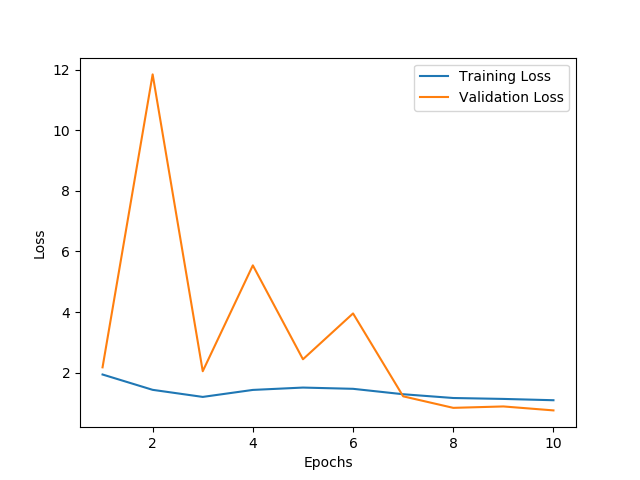
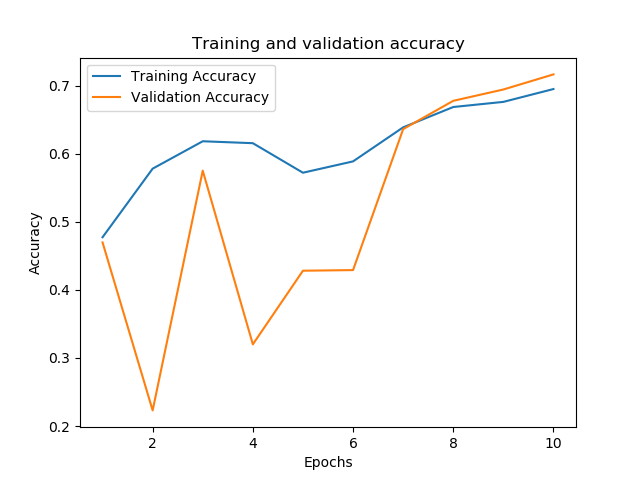

Achieved Accuracy: 0.7169287690512016 

    [[134  25  20   7  18]
     [  9 214  15  24  16]
     [  6  13  91   0  54]
     [  5  17   6 158  13]
     [  3  12  34   9 178]]

Now all that remains is to try training and evaluating the Inception model. You probably have a good idea of how to do this, it's pretty much just what happened with the ResNet model. First, we create the model, add the dense layers, and compile. Then we just fit the generator.

In [ ]:
Incep = InceptionV3(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))
Incep_model = Sequential()
Incep_model.add(Incep)
Incep_model.add(Flatten())
Incep_model.add(Dense(256, activation='relu'))
Incep_model.add(Dropout(0.2))
Incep_model.add(Dense(64, activation='relu'))
Incep_model.add(Dropout(0.2))
Incep_model.add(Dense(5, activation='softmax'))
print(Incep_model.summary())
Incep_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath = "weights_Incep.hdf5"
callbacks = [ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='min', min_lr=0.00001),
             EarlyStopping(monitor= 'val_loss', min_delta=1e-10, patience=15, verbose=1, restore_best_weights=True)]

num_epochs = 10

Incep_records = Incep_model.fit_generator(data_generator.flow(X_train, y_train, batch_size=batch_size), epochs = num_epochs,
                          validation_data=(X_test, y_test), verbose= 1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=callbacks)

Now all that we need to do it check the performance!

In [ ]:
# visualize training loss
# declare important variables
training_acc = Incep_records.history['acc']
val_acc = Incep_records.history['val_acc']
training_loss = Incep_records.history['loss']
validation_loss = Incep_records.history['val_loss']

# gets the length of how long the model was trained for
train_length = range(1, len(training_acc) + 1)

plot_stats(train_length, training_acc, val_acc, training_loss, validation_loss)
make_preds(Incep_model)

Here's what I got while training this model.

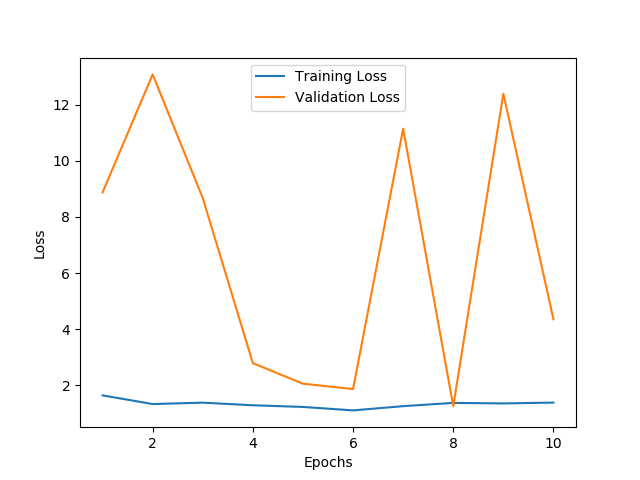
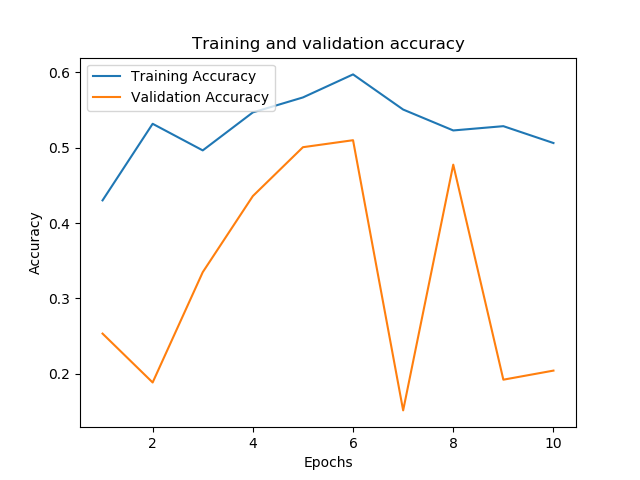

Achieved Accuracy: 0.20444033305254608

    [[ 37   0   0   0 167]
     [ 71   0   0   0 207]
     [ 21   1   0   0 142]
     [ 39   5   0   5 150]
     [ 51   5   0   1 179]]

So the custom model did the best, while the ResNet model did only a little worse than our custom model despite training for less time. Finally, the Inception-based model did the worst in this instance. You can see it is important to choose the right pre-made architecture when doing transfer learning.